# 2024-1 Artificial Intelligence (01)
## Homework #5: Simple Diffusion Model
---
Copyright (c) Prof. Jaehyeong Sim

Department of Computer Science and Engineering

College of Artificial Intelligence

Ewha Womans University

## Guideline
### Introduction
> Here in this homework assignment 5, we will implement a simple diffusion model to generate images like CIFAR-10 dataset using TensorFlow Keras library.

### Details
> This is how the simple diffusion model works: it's like based with a fully noisy image and gradually improves the image quality until it becomes clear.

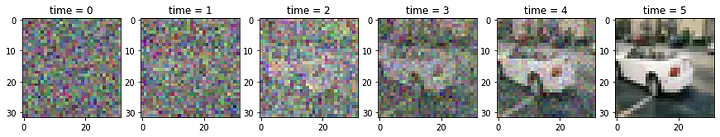

> Therefore, we can create a deep learning model that can improve image quality (from fully noise to clear image), the flow idea is as follows:

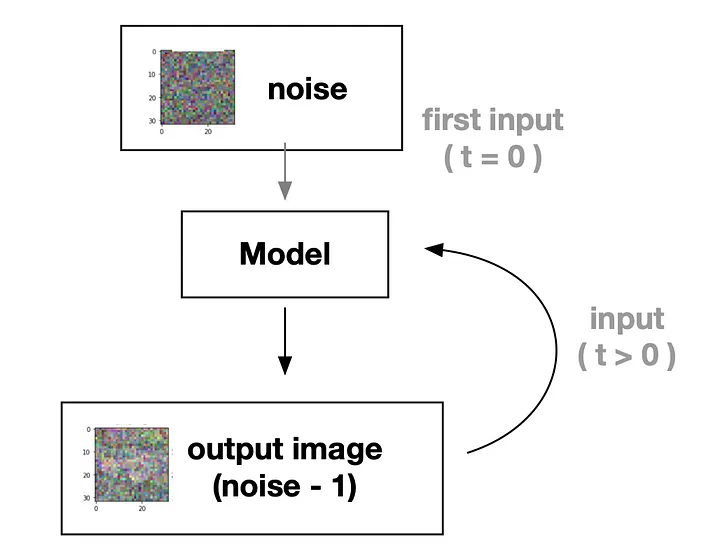

> For a clearer idea, take a look at this additional flow chart:

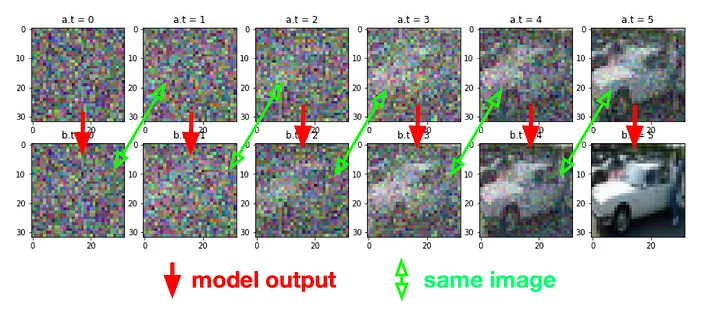

> As you can see in the image above, the model is attempting to produce an image with progressively less noise. Now, we just need to train a Deep Learning model to learn how to reduce noise. For that mission, we need two input in our model:

*   input image — the noise image need to be processed
*   timestamp — tell model what’s noise status so can be easier to learn



### Your job
> Please complete the code. You only have to write the parts marked as **### Please fill here**.

### Submission guide
1. Please rename the completed skeleton file to ***STUDENT_ID*.ipynb**. Your own student ID goes to *STUDENT_ID*. For example, if your student ID is 2412345, the file name should be **2412345.ipynb**
2. Turn in it into the Ewha CyberCampus

⚠ If you doesn't follow the submission guide above, you will get **5 point deduction** from this homework score.

### Importing necessary libraries

In [1]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

### Prepare the dataset

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train[y_train.squeeze() == 1]
X_train = (X_train / 127.5) - 1.0

170498071/170498071 [==============================] - 6s 0us/step


### Define variables

In [3]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

### Some utility functions for preview data

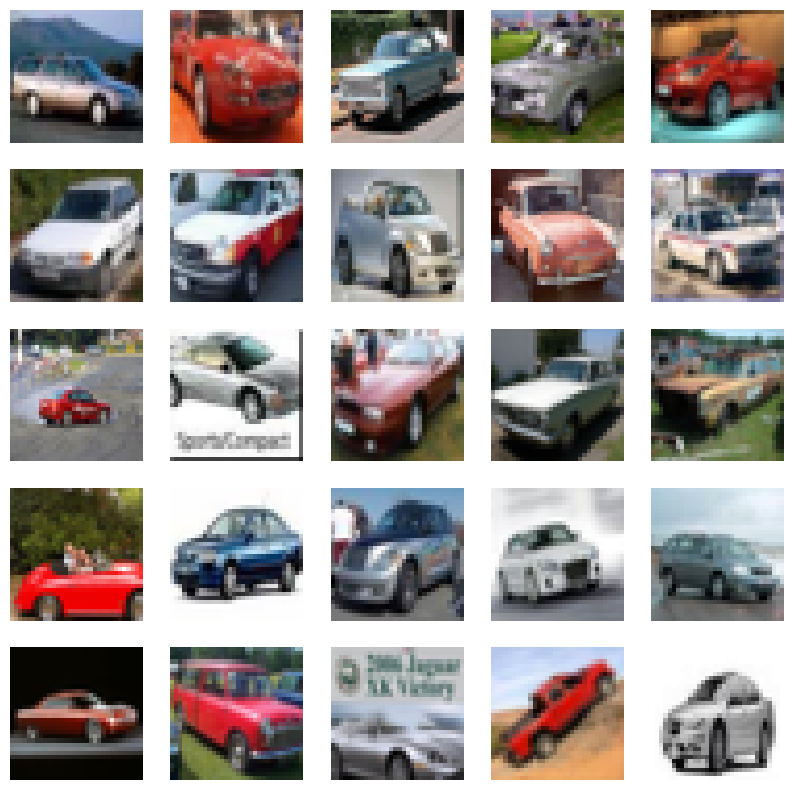

In [4]:
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')

show_examples(X_train)

### Forward process

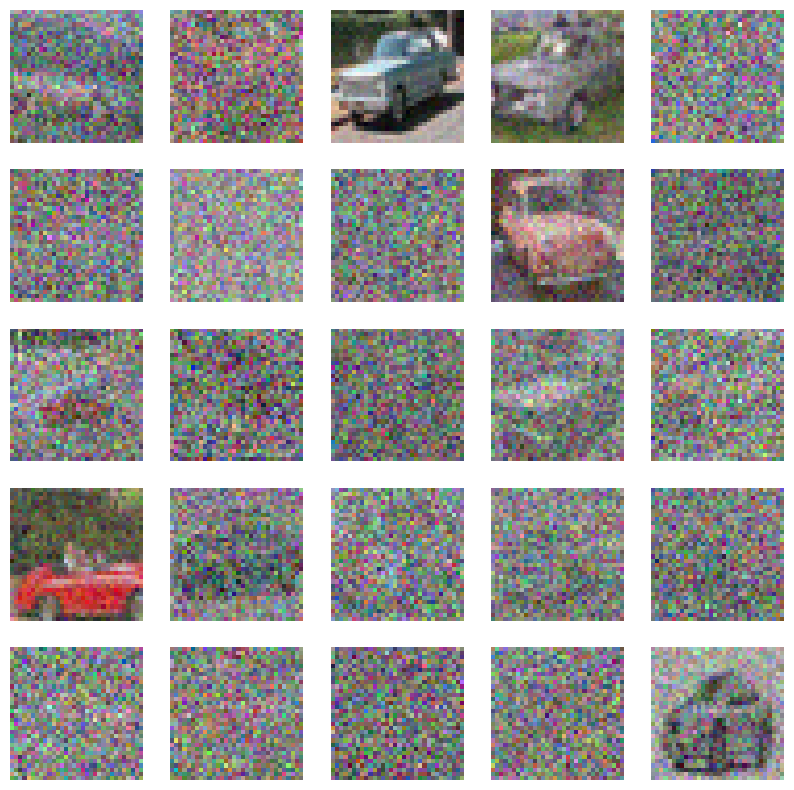

In [5]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1

    noise = np.random.normal(size=x.shape)

    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

t = generate_ts(25)             # random for training data
a, b = forward_noise(X_train[:25], t)
show_examples(a)

### Building a block
> Each block contains two convolutional networks with a time parameter, allowing the network to determine its current time step and output corresponding information.

> You can see block flow chart below.
(x_img is input image which is noisy image, x_ts is input for time step)

Here are some details:

*   Conv2D: 128 channels, 3x3 conv, padding same, ReLU activation (input: x_img, output: x_parameter)
*   Time Parameter: dense layer with 128 hidden units (input: x_ts, output: time_parameter)

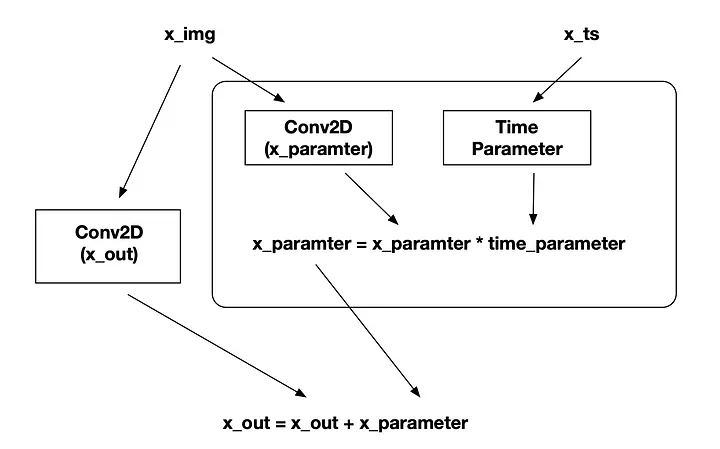



In [6]:
def block(x_img, x_ts):
    x_out = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x_img)

    x_parameter = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x_img)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)

    x_parameter = x_parameter * time_parameter

    x_out = x_out + x_parameter

    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)

    return x_out

### Building an U-Net

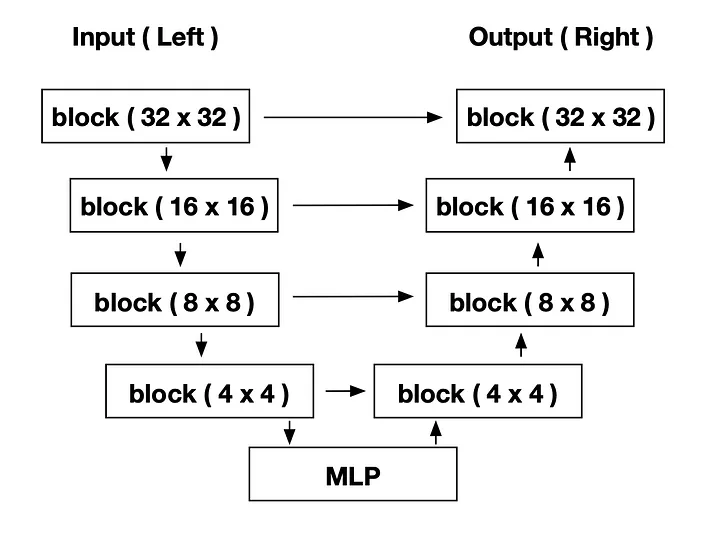

In [7]:
def make_model():
    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')

    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)

    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x4 = block(x, x_ts)

    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)

    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

model = make_model()

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanSquaredError()
model.compile(loss=loss_func, optimizer=optimizer)

### Predict the result

  0%|          | 0/16 [00:00<?, ?it/s]

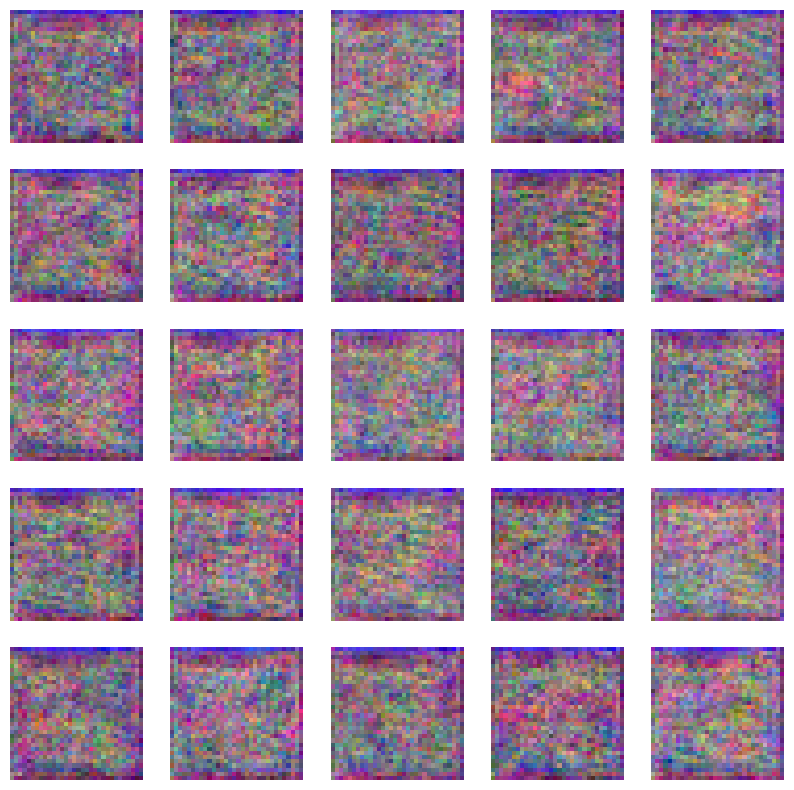

In [9]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))
    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((32), t)], verbose=0)
    show_examples(x)

predict()

### Split the dataset into train and test sets

  0%|          | 0/16 [00:00<?, ?it/s]

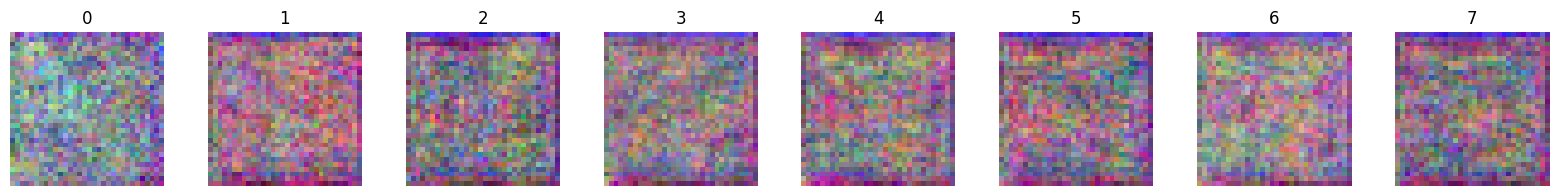

In [10]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

### Training model

Make sure you use GPU/TPU session to accelerate your training process

In [11]:
def train_one(x_img):
    batch_size = x_img.shape[0]
    t = np.random.randint(0, timesteps, size=batch_size)

    a = time_bar[t]
    b = time_bar[t + 1]
    noise = np.random.normal(size=x_img.shape)
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    x_a = x_img * (1 - a) + noise * a
    x_b = x_img * (1 - b) + noise * b

    x_ts = np.expand_dims(t, axis=-1)
    x_ts = np.tile(x_ts, (1, 1))

    loss = model.train_on_batch([x_a, x_ts], x_b)

    return loss

In [12]:
def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

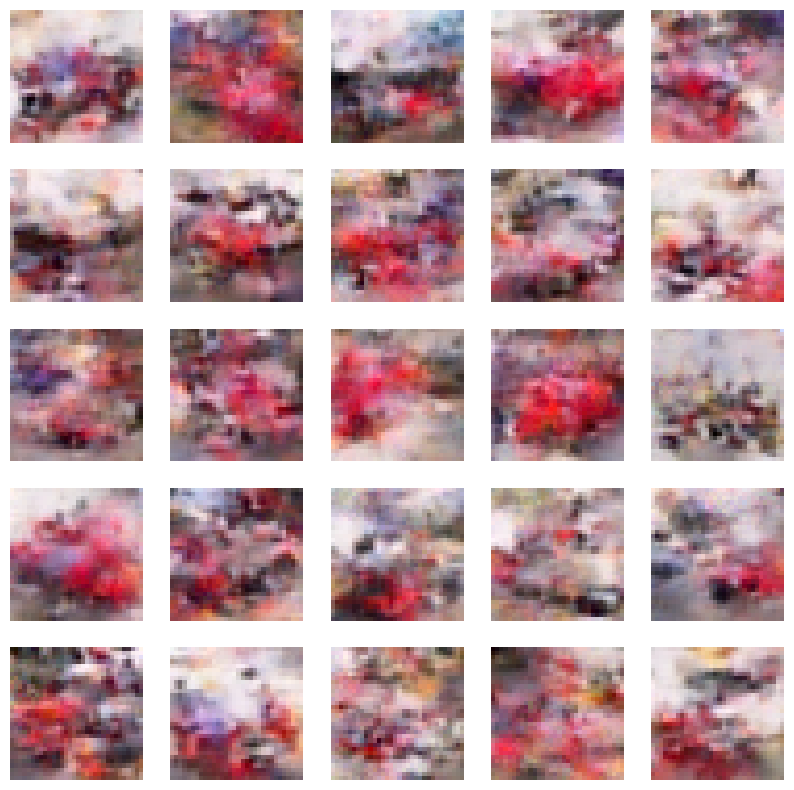

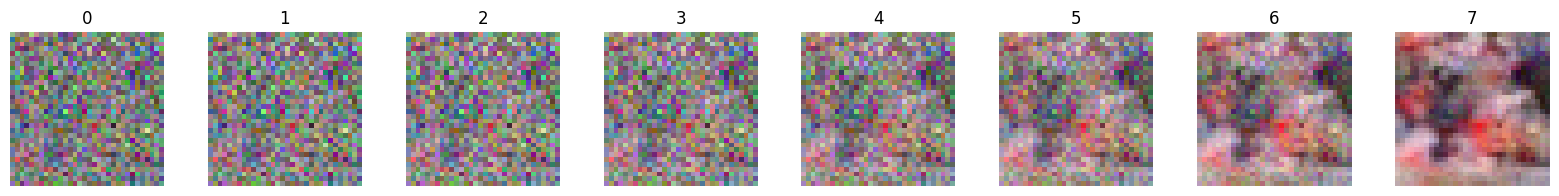

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

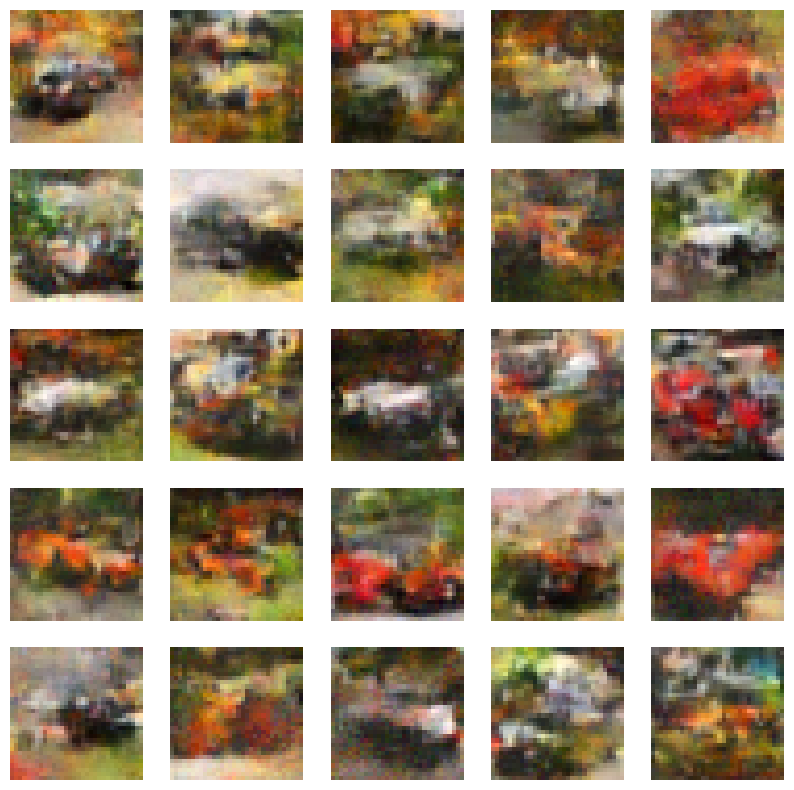

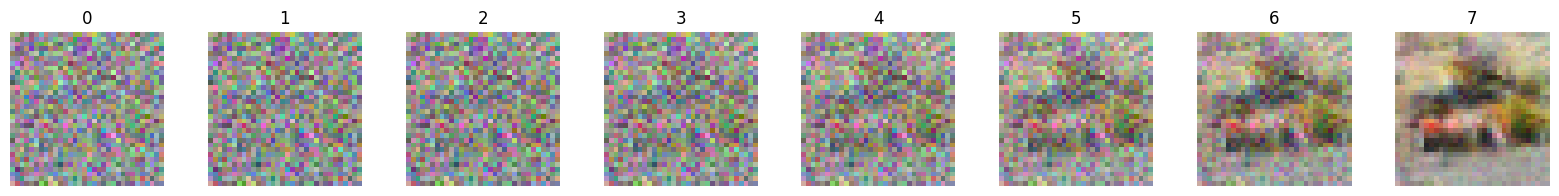

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

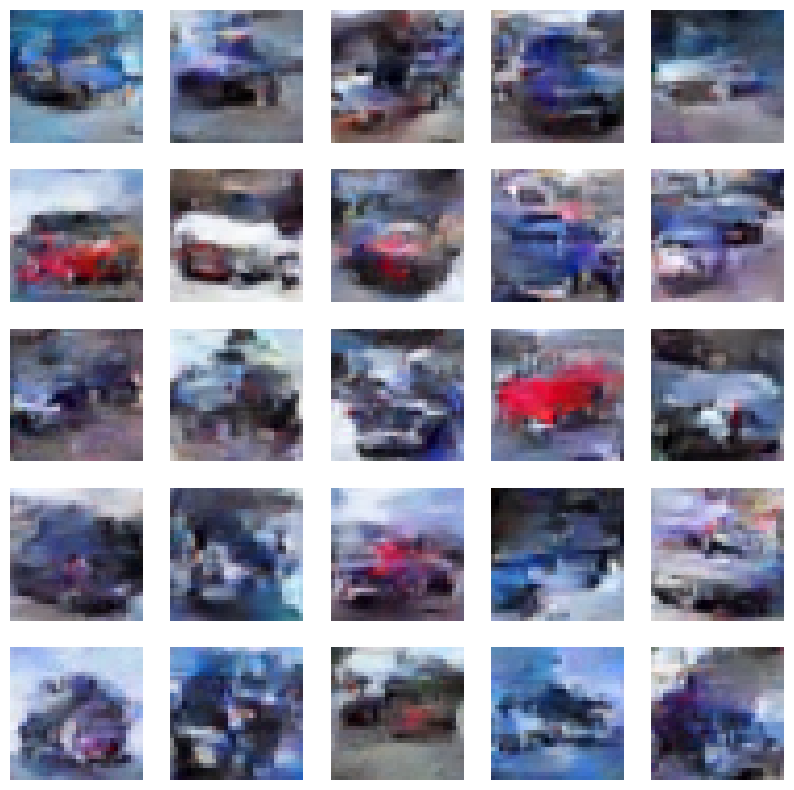

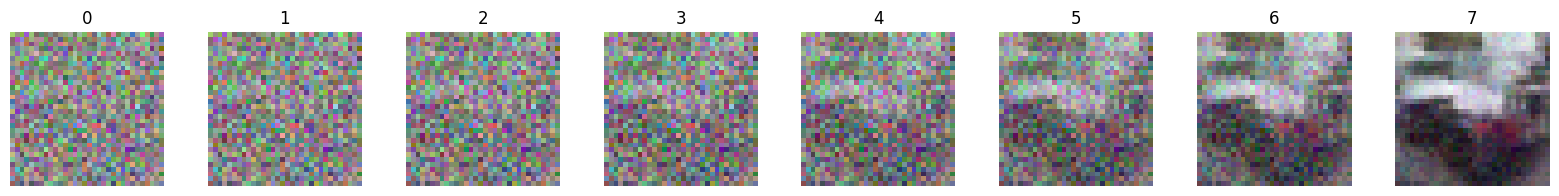

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

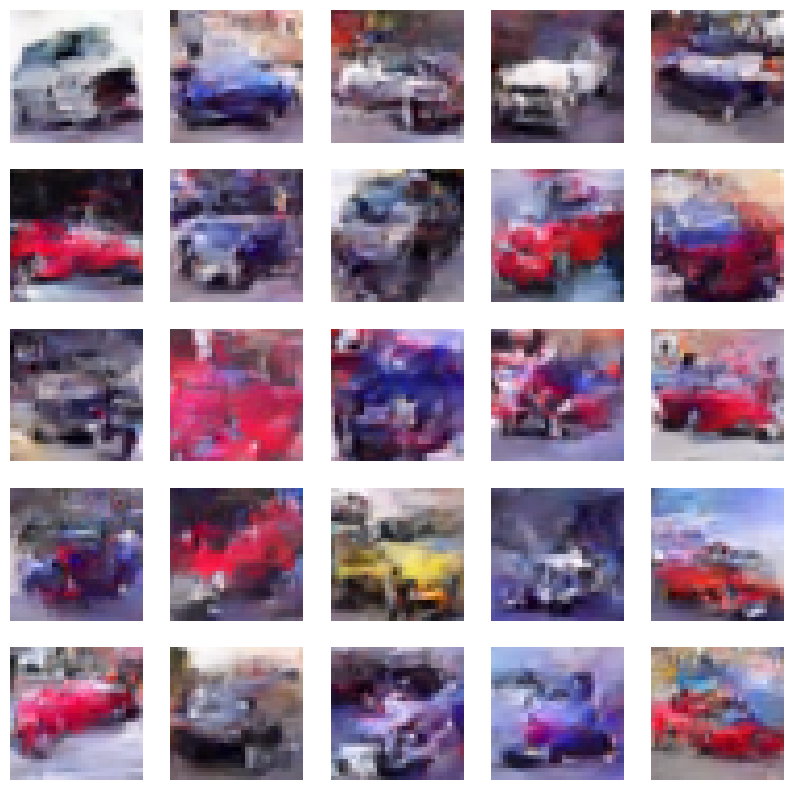

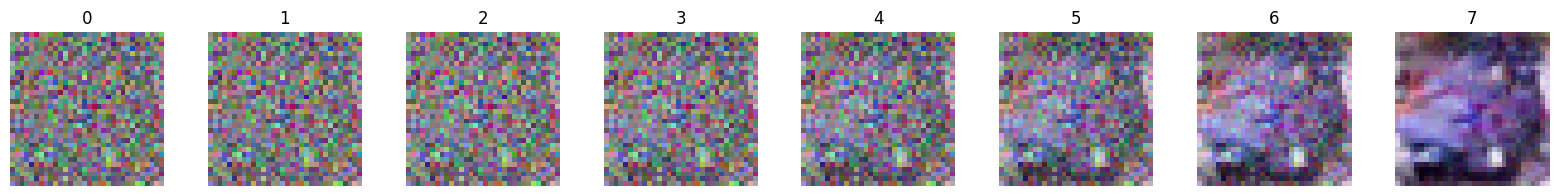

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

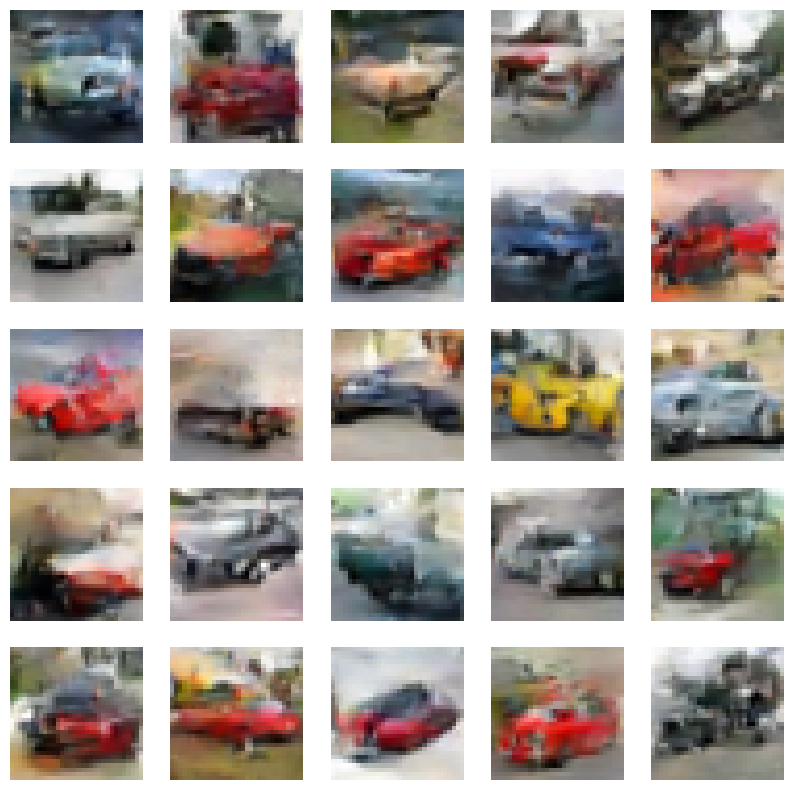

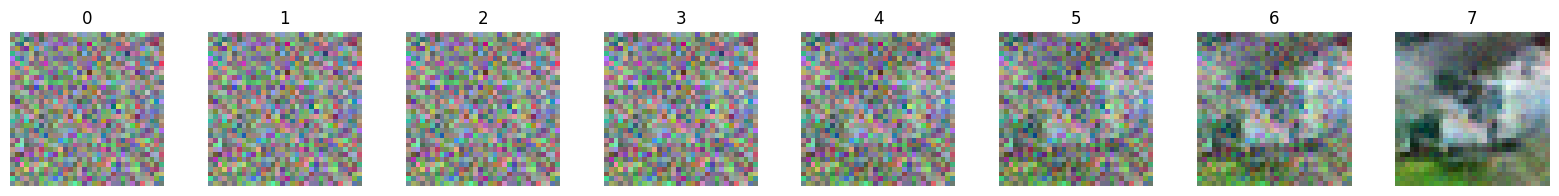

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

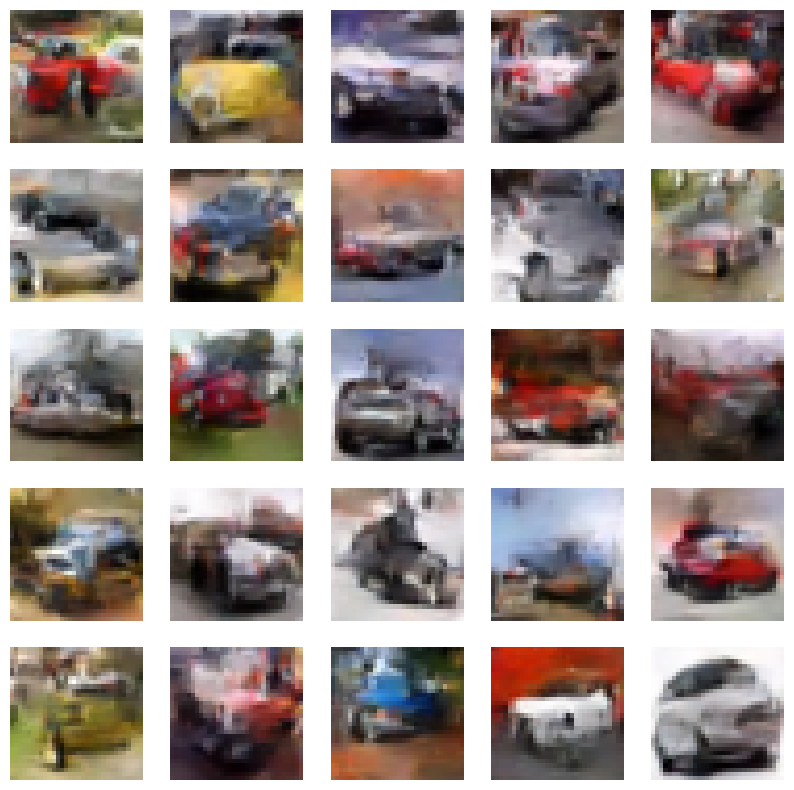

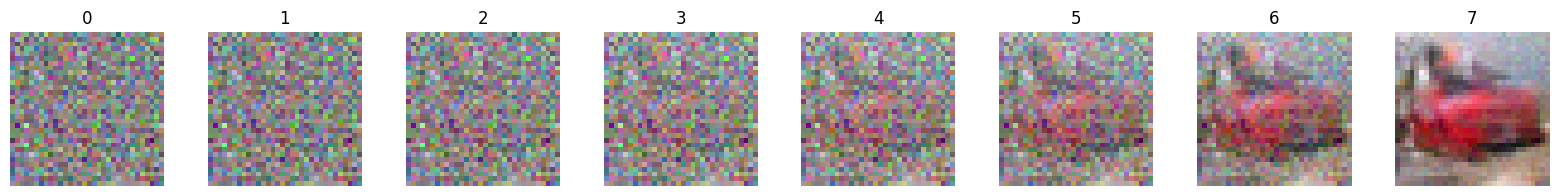

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

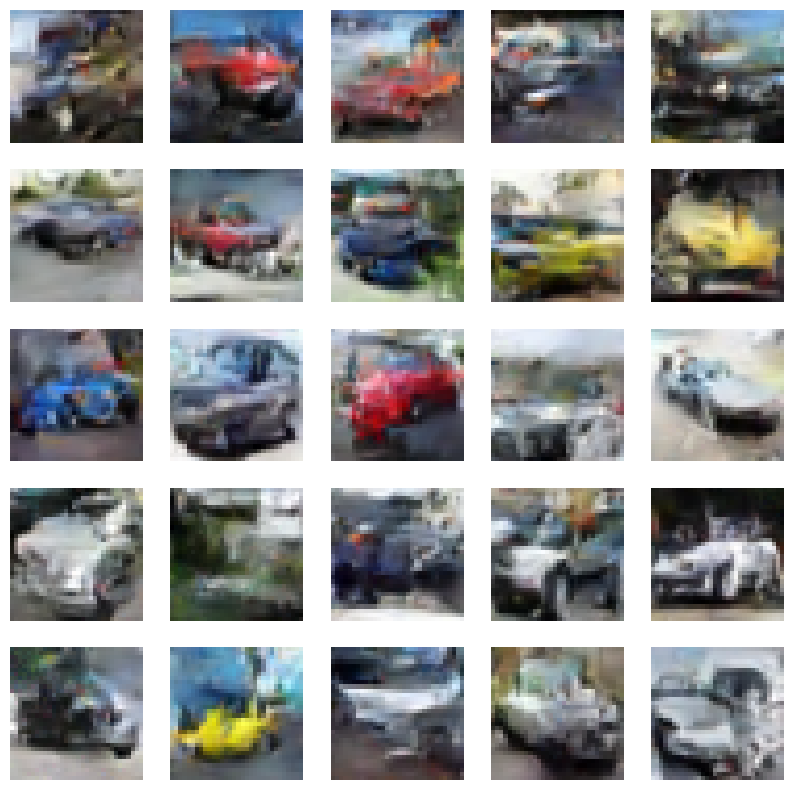

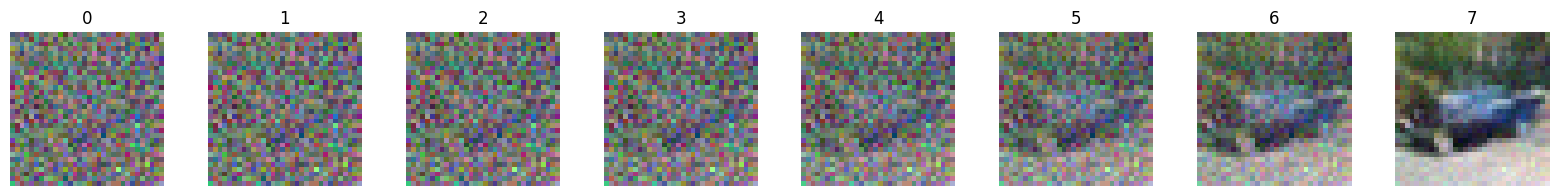

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

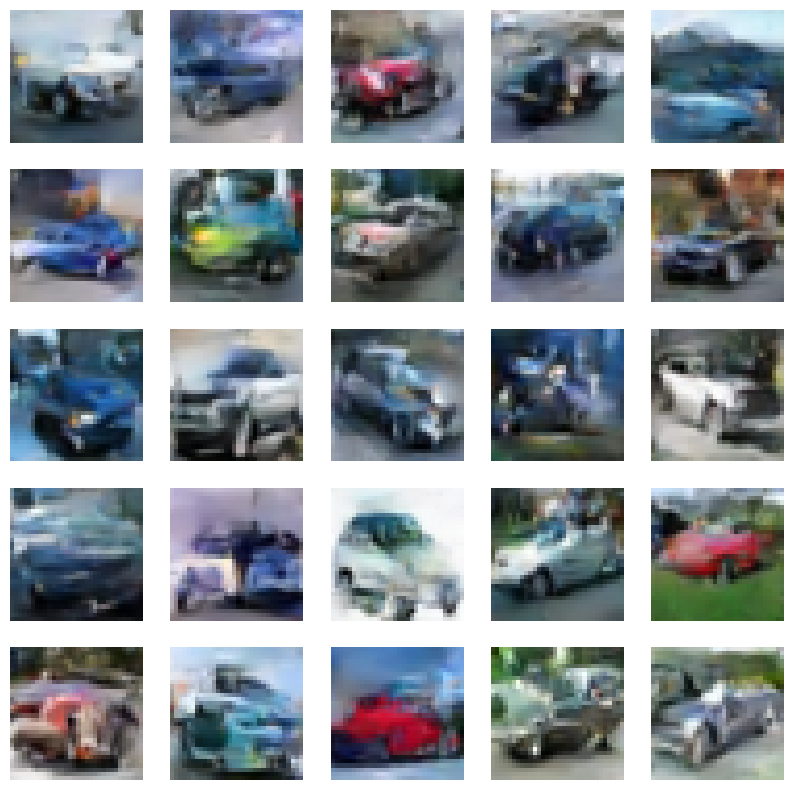

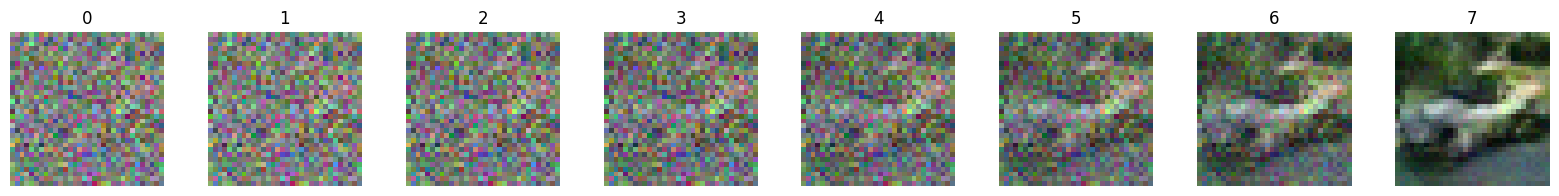

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

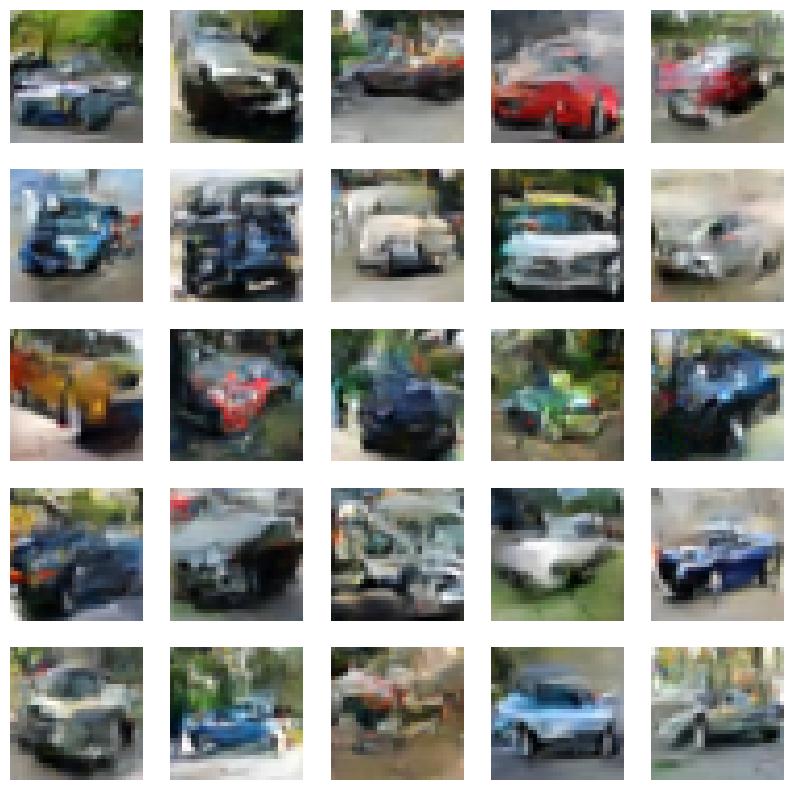

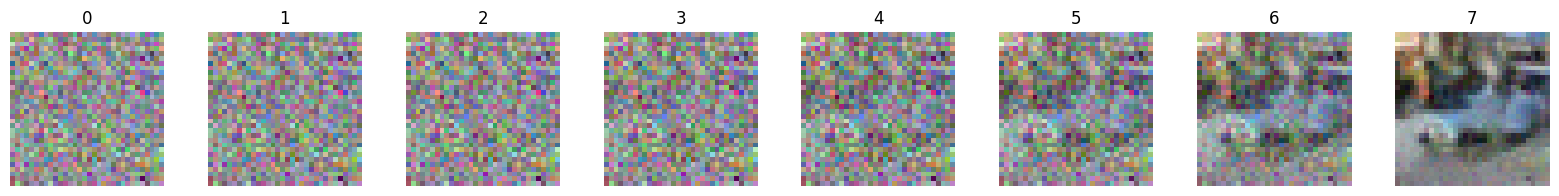

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

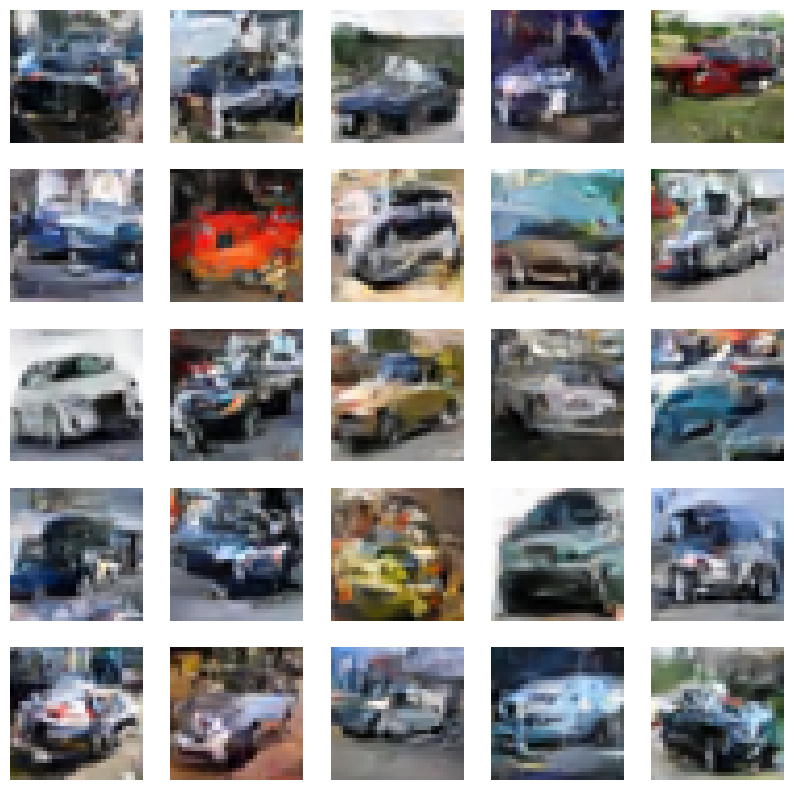

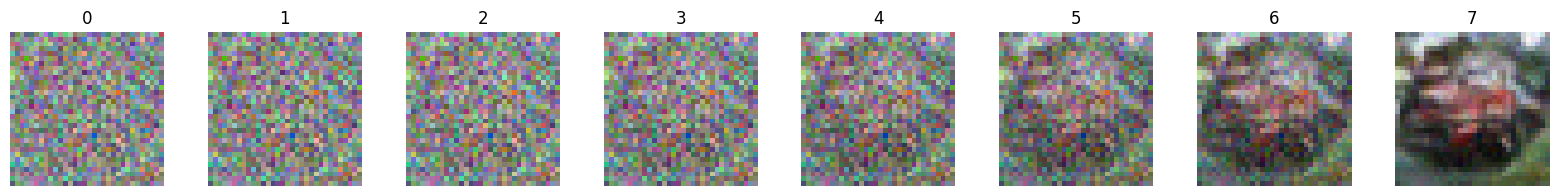

In [13]:
for _ in range(10):
    train()
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

    predict()
    predict_step()
    plt.show()